# Ensemble Classifiers: Reduced Featureset
---

### Pre-Training Setup (Load Reduced-Features Data)

Reduced 18-feature feature-set: ['illday', 'rash', 'redeyes', 'redplt', 'clnode',
		'redhands', 'pwbc', 'ppolys', 'pbands', 'plymphs', 'pmonos',
		'peos', 'pesr', 'pcrp', 'pplts', 'palt', 'pggt', 'zhemo']

In [1]:
import sys
sys.path.append('../') # Make parent folder visible
import numpy as np
from scipy.stats import randint

from sklearn import svm, linear_model, neighbors, ensemble, naive_bayes, \
    neural_network, tree, gaussian_process, discriminant_analysis
    
import matplotlib.pyplot as plt

from preprocess import load_data
from model_helpers.models import compute_confusion, explain_confusion, get_fc_kd_thresholds, \
    test_model, plot_cv_roc_curves, ScikitModel

In [2]:
x, y, ids = load_data.load_expanded(one_hot=False, fill_mode='mean', reduced_features=True)

### Test out Candidate Learners

In [10]:
# SVM
svm_model = ScikitModel(svm.SVC(probability=True), 
                       {
                           'C': np.logspace(-3, 3, 100),
                           'gamma': np.logspace(-3, 3, 100),
                           'kernel': ['linear', 'rbf', 'poly']
                       },
                       random_search=True,
                       n_iter=100,
                       scoring='roc_auc',
                       verbose=True)
svm_rocs = test_model(svm_model,
                      x, y,
                      threshold=0.40)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.5min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.0026560877829466868, 'C': 35.111917342151344}
Best score:  0.974941240561
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.2min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.0061359072734131761, 'C': 4.9770235643321135}
Best score:  0.969932838712
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.4min finished


Best params:  {'kernel': 'linear', 'gamma': 247.7076355991714, 'C': 0.0053366992312063122}
Best score:  0.974221082189
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.7min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.016297508346206444, 'C': 0.61359072734131759}
Best score:  0.969144356767
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params:  {'kernel': 'rbf', 'gamma': 0.0035111917342151308, 'C': 20.092330025650458}
Best score:  0.971500546631
CV Confusion:  [[114, 11, 14, 150], [111, 14, 5, 159], [102, 22, 12, 152], [111, 13, 5, 159], [102, 22, 6, 158]]
Best CV scores:  [ 0.9749  0.9699  0.9742  0.9691  0.9715]
Avg best scores:  0.971948012972
FC Classified as FC: 108.0, (86.8167202572 %)
FC Classified as KD: 16.4, (13.1832797428 %)
KD Classified as FC: 8.4, (5.12195121951 %)
KD Classified as KD: 155.6, (94.8780487805 %)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.1min finished


In [3]:
# Logistic Regression
lr_model = ScikitModel(linear_model.LogisticRegression(), 
                       params={
                           'C': np.logspace(-2, 2, 5)
                       },
                       random_search=False,
                       scoring='roc_auc',
                       verbose=True)
lr_rocs = test_model(lr_model,
                     x, y,
                     threshold=0.4)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


Best params:  {'C': 0.01}
Best score:  0.974585786227
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.967782408876
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


Best params:  {'C': 100.0}
Best score:  0.974463743231
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.968702228605
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.971804104121
CV Confusion:  [[109, 16, 8, 156], [109, 16, 4, 160], [105, 19, 10, 154], [109, 15, 3, 161], [94, 30, 6, 158]]
Best CV scores:  [ 0.9746  0.9678  0.9745  0.9687  0.9718]
Avg best scores:  0.971467654212
FC Classified as FC: 105.2, (84.5659163987 %)
FC Classified as KD: 19.2, (15.4340836013 %)
KD Classified as FC: 6.2, (3.78048780488 %)
KD Classified as KD: 157.8, (96.2195121951 %)


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


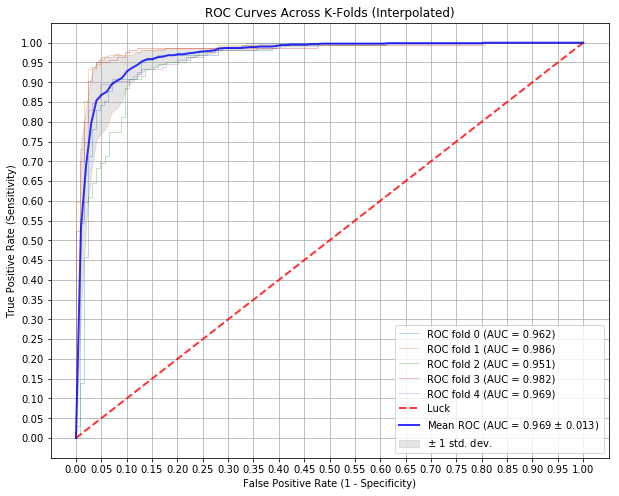

In [12]:
plot_cv_roc_curves(lr_rocs)

In [13]:
# Random Forest
rf_model = ScikitModel(ensemble.RandomForestClassifier(), 
                       params={
                           'n_estimators': randint(10, 500),
                           'max_features': randint(3, 15),
                           'min_samples_split': randint(2, 50),
                           'min_samples_leaf': randint(1, 50)
                       },
                       random_search=True,
                       n_iter=250,
                       scoring='roc_auc',
                       verbose=True)
rf_rocs = test_model(rf_model,
                     x, y,
                     threshold=0.4)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.5min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 23, 'n_estimators': 282}
Best score:  0.973162680211
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 13.2min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 476}
Best score:  0.969990674273
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 13.0min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 291}
Best score:  0.971530653085
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.3min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 21, 'min_samples_split': 26, 'n_estimators': 425}
Best score:  0.968820883769
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 11.7min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 27, 'n_estimators': 259}
Best score:  0.973292366426
CV Confusion:  [[108, 17, 9, 155], [104, 21, 3, 161], [105, 19, 9, 155], [102, 22, 2, 162], [91, 33, 4, 160]]
Best CV scores:  [ 0.9732  0.97    0.9715  0.9688  0.9733]
Avg best scores:  0.971359451553
FC Classified as FC: 102.0, (81.9935691318 %)
FC Classified as KD: 22.4, (18.0064308682 %)
KD Classified as FC: 5.4, (3.29268292683 %)
KD Classified as KD: 158.6, (96.7073170732 %)


## Sklearn Ensemble Model

In [14]:
# Grid search params
clf1 = svm.SVC(probability=True)
clf2 = linear_model.LogisticRegression()

eclf = ensemble.VotingClassifier(
    estimators=[('svm', clf1), ('lr', clf2)],
    voting='soft')

params = {
    'svm__C': np.logspace(-3, 2, 100),
    'svm__gamma': np.logspace(-3, 2, 100),
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'lr__C': np.logspace(-3, 2, 100)
}

# Test model! 5-fold CV with hyperparameter optimization
clf = ScikitModel(
    eclf,
    params,
    random_search=True, 
    n_iter=100, 
    verbose=True)

ensemble_rocs = test_model(clf, x, y, threshold=0.4)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.020565123083486514, 'svm__C': 0.47508101621027982, 'lr__C': 0.42292428743894989}
Best score:  0.975522688468
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.0057223676593502202, 'svm__C': 12.32846739442066, 'lr__C': 0.032745491628777282}
Best score:  0.970010072722
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.0091116275611548871, 'svm__C': 4.3287612810830574, 'lr__C': 49.770235643321136}
Best score:  0.975324735174
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.020565123083486514, 'svm__C': 39.442060594376564, 'lr__C': 0.10476157527896651}
Best score:  0.970324147851
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.0011233240329780276, 'svm__C': 0.47508101621027982, 'lr__C': 0.53366992312063066}
Best score:  0.97249353511
CV Confusion:  [[112, 13, 15, 149], [110, 15, 4, 160], [104, 20, 10, 154], [111, 13, 6, 158], [102, 22, 8, 156]]
Best CV scores:  [ 0.9755  0.97    0.9753  0.9703  0.9725]
Avg best scores:  0.972735035865
FC Classified as FC: 107.8, (86.6559485531 %)
FC Classified as KD: 16.6, (13.3440514469 %)
KD Classified as FC: 8.6, (5.24390243902 %)
KD Classified as KD: 155.4, (94.756097561 %)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.3min finished


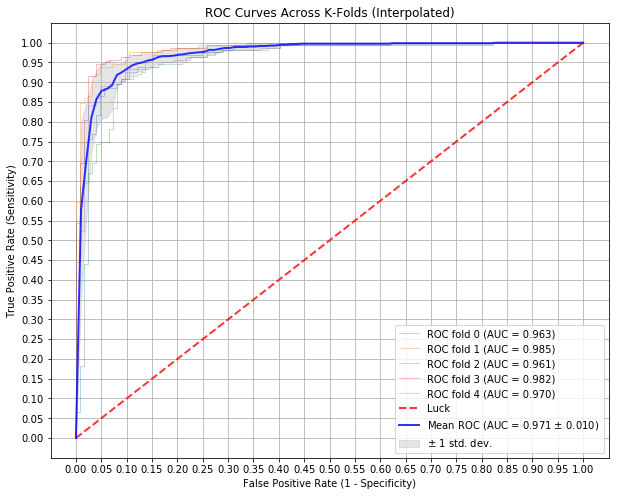

In [15]:
plot_cv_roc_curves(ensemble_rocs)